In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATADIR = "/content/drive/MyDrive/Biomedical/IITD Palmprint V1"
STOREDIR = '/content/drive/MyDrive/PalmData/Output/'
ROIFOLDER = STOREDIR+'ROI'
MODELFOLDER = STOREDIR+'model/FEATURES' 
CATEGORIES = ["Left Hand", "Right Hand"]
FINAL_H = 256.
FINAL_W = 340.

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np


# All the 6 methods for comparison in a list
def templateMatching(img,template):
  w, h = template.shape[::-1]
  methods = [ 'cv2.TM_CCORR']
  for meth in methods:
      method = eval(meth)

      # Apply template Matching
      res = cv2.matchTemplate(img,template,method)
      min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

      # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
      if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
          top_left = min_loc
      else:
          top_left = max_loc
      bottom_right = (top_left[0] + w, top_left[1] + h)
      cv2.rectangle(img,top_left, bottom_right, 255, 2)

      # plt.subplot(121),plt.imshow(res,cmap = 'gray')
      # plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
      # plt.subplot(122),plt.imshow(img,cmap = 'gray')
      # plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
      # plt.suptitle(meth)
      # plt.show()
      h,w = img.shape     
      top_left_x =(int) ((top_left[0] * FINAL_W )/ w)
      top_left_y = (int)((top_left[1] * FINAL_H )/ h)
      bottom_right_x = (int)((bottom_right[0] * FINAL_W )/ w)
      bottom_right_y = (int)((bottom_right[1] * FINAL_H )/ h)
      
      return top_left_x,top_left_y,bottom_right_x,bottom_right_y
not_exist = []
with open(STOREDIR+'config.txt', 'w') as writer:
      for category in CATEGORIES:
          filePath = os.path.join(DATADIR, category)   # paths to left and right dir
          SegmentedCategory = category.split(' ')[0]
          i = 1
          for fileName in os.listdir(filePath):
            print('start with'+fileName)
            if(os.path.isfile(os.path.join(DATADIR,'Segmented',SegmentedCategory,fileName.split('.')[0]+'.bmp'))):
              img = cv2.imread(os.path.join(filePath,fileName),0)
              template = cv2.imread(os.path.join(DATADIR,'Segmented',SegmentedCategory,fileName.split('.')[0]+'.bmp'),0)
              scale_percent = 35  # percent of original size
              width = int(img.shape[1] * scale_percent / 100)
              height = int(img.shape[0] * scale_percent / 100)
              dim = (width, height)
              img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) 
              top_left_x,top_left_y,bottom_right_x,bottom_right_y=templateMatching(img,template)
              img = cv2.imread(os.path.join(filePath,fileName))
              img_resized= cv2.resize(img,(int (FINAL_W),int (FINAL_H)))
              #cv2.rectangle(img_resized,(top_left_x,top_left_y),(bottom_right_x,bottom_right_y),255,1)
              gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
              blur = cv2.GaussianBlur(gray, (5, 5), 0)
              ret, thresh = cv2.threshold(blur,100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
              kernel = np.ones((5, 5), np.uint8)
              maskForROI = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
              palmFeatures = cv2.bitwise_and(img_resized, img_resized,mask = thresh)
              print("Current Image :"+str (i))
              # plt.imshow(img_resized, cmap="gray")
              # plt.show()
              # plt.imshow(palmFeatures, cmap = "gray")
              # plt.show()
              cv2.imwrite(STOREDIR+SegmentedCategory+'_'+fileName.split('.')[0]+'.png',img_resized)
              writer.write(SegmentedCategory+'_'+fileName.split('.')[0]+'.png '+str(top_left_x)+' '+str(top_left_y)+' '+str(bottom_right_x)+' '+str(bottom_right_y)+'\n')
              print("Done with File:"+fileName)
              i = i + 1
            else:
              not_exist.append(fileName)
print(not_exist)


Streaming output truncated to the last 5000 lines.
Current Image :932
Done with File:229_5.JPG
start with229_6.JPG
Current Image :933
Done with File:229_6.JPG
start with048_1.JPG
Current Image :934
Done with File:048_1.JPG
start with048_2.JPG
Current Image :935
Done with File:048_2.JPG
start with048_3.JPG
Current Image :936
Done with File:048_3.JPG
start with048_4.JPG
Current Image :937
Done with File:048_4.JPG
start with048_5.JPG
Current Image :938
Done with File:048_5.JPG
start with048_6.JPG
Current Image :939
Done with File:048_6.JPG
start with172_1.JPG
Current Image :940
Done with File:172_1.JPG
start with172_2.JPG
Current Image :941
Done with File:172_2.JPG
start with172_3.JPG
Current Image :942
Done with File:172_3.JPG
start with172_4.JPG
Current Image :943
Done with File:172_4.JPG
start with172_5.JPG
Current Image :944
Done with File:172_5.JPG
start with172_6.JPG
Current Image :945
Done with File:172_6.JPG
start with181_1.JPG
Current Image :946
Done with File:181_1.JPG
start wit

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 32

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
with open(STOREDIR+'config.txt', 'r') as reader:
  rows = reader.readlines()
data = []
targets = []
filenames = []
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
  row = row.split(" ")
  (filename, startX, startY, endX, endY) = row
  imagePath = os.path.sep.join([STOREDIR, filename])
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
print("[INFO] saving testing filenames...")
f = open(STOREDIR+'model/test_images.txt', "w")
f.write("\n".join(testFilenames))
f.close()


[INFO] saving testing filenames...


In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

[INFO] saving object detector model...


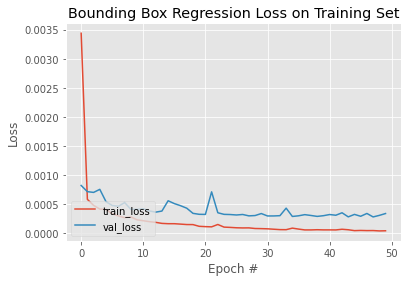

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(STOREDIR+'model/detector.h5', save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(STOREDIR+'model/plot.png')

In [ ]:
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt
# import numpy as np
# import mimetypes
# import argparse
# import imutils
# import cv2
# import os
# filenames = open(STOREDIR+'model/test_images.txt').read().strip().split("\n")
# imagePaths = []
# for f in filenames:
#   p = os.path.sep.join([STOREDIR, f])
#   imagePaths.append(p)

# print("[INFO] loading object detector...")
# trained_model = load_model(STOREDIR+'model/detector.h5')
# for imagePath in imagePaths:
#   image = load_img(imagePath, target_size=(224, 224))
#   image = img_to_array(image) / 255.0
#   image = np.expand_dims(image, axis=0)
#   preds = trained_model.predict(image)[0]
#   (startX, startY, endX, endY) = preds
#   image = cv2.imread(imagePath)
#   (h, w) = image.shape[:2]
#   startX = int(startX * w)
#   startY = int(startY * h)
#   endX = int(endX * w)
#   endY = int(endY * h)
#   crop_image = image[startY:endY,startX:endX]
#   cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
#   # show the output image
#   plt.imshow(crop_image)
#   plt.show()

In [ ]:
#Data storing
pathToStoreROI =STOREDIR+'ROI'
!mkdir -p $pathToStoreROI
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os


print("[INFO] loading object detector...")
trained_model = load_model(STOREDIR+'model/detector.h5')

with open(STOREDIR+'config.txt', 'r') as reader:
  rows = reader.readlines()
for row in rows:
	# break the row into the filename and bounding box coordinates
  row = row.split(" ")
  (filename, startX, startY, endX, endY) = row
  imagePath = STOREDIR+filename
  print(imagePath)
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
  preds = trained_model.predict(image)[0]
  (startX, startY, endX, endY) = preds
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)
  crop_image = image[startY:endY,startX:endX]
  print(STOREDIR+'ROI/'+filename)
  cv2.imwrite(STOREDIR+'ROI/'+filename,crop_image)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/PalmData/Output/Left_079_2.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_079_2.png
/content/drive/MyDrive/PalmData/Output/Left_079_3.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_079_3.png
/content/drive/MyDrive/PalmData/Output/Left_079_4.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_079_4.png
/content/drive/MyDrive/PalmData/Output/Left_079_5.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_079_5.png
/content/drive/MyDrive/PalmData/Output/Left_080_1.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_080_1.png
/content/drive/MyDrive/PalmData/Output/Left_080_2.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_080_2.png
/content/drive/MyDrive/PalmData/Output/Left_080_3.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_080_3.png
/content/drive/MyDrive/PalmData/Output/Left_080_4.png
/content/drive/MyDrive/PalmData/Output/ROI/Left_080_4.png
/content/drive/MyDrive/PalmData/Output/Left_080_5.png

In [ ]:
BATCH_SIZE_FEM = 32
LE_PATH = MODELFOLDER+ "/le.cpickle"
BASE_CSV_PATH = "output"

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import  VGG16 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import numpy as np
import pickle
import random
import os
print("[INFO] loading network...")
model =  VGG16(weights="imagenet", include_top=False)
le = None
p = STOREDIR + 'ROI/'
imagePaths = list(paths.list_images(p))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-1].split('_')[0][0]+p.split(os.path.sep)[-1].split('_')[1] for p in imagePaths]
print('labels:')
print(labels)
_, unique_indices = np.unique(labels, return_index=True)
FEM_testImagePaths = np.array(imagePaths)[np.array(unique_indices)]
FEM_testImageLables = np.array(labels)[np.array(unique_indices)]
labels = np.delete(labels,unique_indices)
imagePaths = np.delete(imagePaths, unique_indices)

if le is None:
  le = LabelEncoder()
  le.fit(labels)
print(len(le.classes_))
for split in ('train','test'):
  csvPath = MODELFOLDER + '/feature_extraction_'+split+'.csv'
  csv = open(csvPath, "w")
  if (split == 'test'):
    imagePaths = FEM_testImagePaths
    labels = FEM_testImageLables
  for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE_FEM)):
    print("[INFO] processing batch {}/{}".format(b + 1,
      int(np.ceil(len(imagePaths) / float(BATCH_SIZE_FEM)))))
    batchPaths = imagePaths[i:i + BATCH_SIZE_FEM]
    batchLabels = le.transform(labels[i:i + BATCH_SIZE_FEM])
    batchImages = []
    for imagePath in batchPaths:
      image = load_img(imagePath, target_size=(224, 224))
      image = img_to_array(image)
      image = np.expand_dims(image, axis=0)
      image = preprocess_input(image)
      batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=BATCH_SIZE_FEM)
    features = features.reshape((features.shape[0], 7 * 7 * 512))
    for (label, vec) in zip(batchLabels, features):
      vec = ",".join([str(v) for v in vec])
      csv.write("{},{}\n".format(label, vec))
  csv.close()
  f = open(LE_PATH, "wb")
  f.write(pickle.dumps(le))
  f.close()

[INFO] loading network...
labels:
['L039', 'L007', 'R215', 'R165', 'R208', 'R031', 'L071', 'L085', 'R056', 'L166', 'R108', 'R206', 'L213', 'L033', 'R224', 'L074', 'L102', 'R147', 'L042', 'R186', 'R158', 'R118', 'L042', 'R094', 'L008', 'R130', 'L070', 'R138', 'R192', 'R075', 'R212', 'R218', 'R080', 'R140', 'R218', 'R093', 'L034', 'L151', 'L050', 'R157', 'L202', 'L123', 'L183', 'R115', 'R074', 'R086', 'L207', 'L210', 'R228', 'L215', 'L090', 'R015', 'R042', 'R010', 'R089', 'L193', 'L195', 'R084', 'R172', 'R133', 'L133', 'L164', 'L199', 'L076', 'L031', 'L095', 'R158', 'R168', 'L041', 'L011', 'L182', 'R088', 'R085', 'L170', 'R076', 'L024', 'L069', 'L029', 'R052', 'R169', 'R213', 'R009', 'R088', 'R209', 'R119', 'L017', 'L216', 'R028', 'L136', 'R041', 'R050', 'L092', 'L049', 'R186', 'L023', 'L186', 'R183', 'R127', 'R056', 'R072', 'R215', 'L044', 'R100', 'L119', 'R069', 'R213', 'R191', 'L143', 'L045', 'L146', 'R144', 'L188', 'L043', 'R014', 'R097', 'R229', 'L121', 'L182', 'L218', 'R143', 'L052

In [ ]:
!ls -l $MODELFOLDER

total 238972
-rw------- 1 root root  52667838 Feb 17 05:23 feature_extraction_test.csv
-rw------- 1 root root 192038505 Feb 17 04:56 feature_extraction_train.csv


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import pickle
import os
def load_data_split(Path):
    data = []
    labels = []
    for row in open(Path):
        row = row.strip().split(",")
        label = row[0]
        features = np.array(row[1:], dtype="float")
        data.append(features)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return (data, labels)
#Require Spliting logic
 
trainingPath = MODELFOLDER + '/feature_extraction_train.csv'
testingPath = MODELFOLDER + '/feature_extraction_test.csv'
 
print("[INFO] loading data...")
(trainX, trainY) = load_data_split(trainingPath)
(testX, testY) = load_data_split(testingPath)
le = pickle.loads(open(LE_PATH, "rb").read())
 
print("[INFO] training model...")
model = LogisticRegression(solver="lbfgs", multi_class="auto",max_iter=150 , verbose=1)
model.fit(trainX, trainY)
# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(testX)
print(classification_report(testY, preds, target_names=le.classes_))
print("[INFO] saving model...")
f = open(MODELFOLDER+'/FEM_logistic_model.cpickle', "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] loading data...
[INFO] training model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished


[INFO] evaluating...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        L001       0.50      1.00      0.67         1
        L002       1.00      1.00      1.00         1
        L003       1.00      1.00      1.00         1
        L004       1.00      1.00      1.00         1
        L005       1.00      1.00      1.00         1
        L006       1.00      1.00      1.00         1
        L007       1.00      1.00      1.00         1
        L008       1.00      1.00      1.00         1
        L009       1.00      1.00      1.00         1
        L010       1.00      1.00      1.00         1
        L011       1.00      1.00      1.00         1
        L012       1.00      1.00      1.00         1
        L013       1.00      1.00      1.00         1
        L014       1.00      1.00      1.00         1
        L015       1.00      1.00      1.00         1
        L016       1.00      1.00      1.00         1
        L017       1.00      1.00      1.00         1
        L018       1.00    

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pickle
import os
def load_data_split(Path):
    data = []
    labels = []
    for row in open(Path):
        row = row.strip().split(",")
        label = row[0]
        features = np.array(row[1:], dtype="float")
        data.append(features)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return (data, labels)
#Require Spliting logic
 
trainingPath = MODELFOLDER + '/feature_extraction_train.csv'
testingPath = MODELFOLDER + '/feature_extraction_test.csv'
 
print("[INFO] loading data...")
(trainX, trainY) = load_data_split(trainingPath)
(testX, testY) = load_data_split(testingPath)
le = pickle.loads(open(LE_PATH, "rb").read())

# Fitting SVM to the Training set
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
classifier = SVC(kernel = 'linear', random_state = 0)
trained_model=classifier.fit(trainX, trainY)
trained_model.fit(trainX, trainY )
# Predicting the Test set results
y_pred = classifier.predict(testX)
print("SVM classification report:",classification_report(testY, y_pred, target_names=le.classes_ ))



#Fitting RF to the Training set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(trainX,trainY)

y_pred=clf.predict(testX)
print("random forest classification report:",classification_report(testY, y_pred, target_names=le.classes_ ))
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Model Accuracy, how often is the classifier correct?
#print("Accuracy score of train Random_forest")
#print(accuracy_score(trainY, trained_model.predict(trainX))*100)


#print("Accuracy score of test random forest:",metrics.accuracy_score(testY, y_pred))



# Fitting KNN to the Training set

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
knn = []
classifier = KNeighborsClassifier(n_neighbors=5)
trained_model=classifier.fit(trainX,trainY)
trained_model.fit(trainX,trainY )

# Predicting the Test set results
y_pred = classifier.predict(testX)
print("KNN:",classification_report(testY, y_pred, target_names=le.classes_ ))



[INFO] loading data...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM classification report:               precision    recall  f1-score   support

        L001       0.50      1.00      0.67         1
        L002       1.00      1.00      1.00         1
        L003       1.00      1.00      1.00         1
        L004       0.00      0.00      0.00         1
        L005       1.00      1.00      1.00         1
        L006       1.00      1.00      1.00         1
        L007       1.00      1.00      1.00         1
        L008       1.00      1.00      1.00         1
        L009       1.00      1.00      1.00         1
        L010       1.00      1.00      1.00         1
        L011       0.00      0.00      0.00         1
        L012       1.00      1.00      1.00         1
        L013       1.00      1.00      1.00         1
        L014       1.00      1.00      1.00         1
        L015       1.00      1.00      1.00         1
        L016       1.00      1.00      1.00         1
        L017       0.50      1.00      0.67         1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        L001       0.33      1.00      0.50         1
        L002       1.00      1.00      1.00         1
        L003       0.00      0.00      0.00         1
        L004       0.00      0.00      0.00         1
        L005       0.00      0.00      0.00         1
        L006       1.00      1.00      1.00         1
        L007       1.00      1.00      1.00         1
        L008       1.00      1.00      1.00         1
        L009       0.00      0.00      0.00         1
        L010       1.00      1.00      1.00         1
        L011       0.00      0.00      0.00         1
        L012       0.00      0.00      0.00         1
        L013       1.00      1.00      1.00         1
        L014       0.25      1.00      0.40         1
        L015       0.00      0.00      0.00         1
        L016       1.00      1.00      1.00         1
        L017       0.00      0.00      0.00         1
        L018       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import  VGG16 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import numpy as np
import pickle
import random
import os
print("[INFO] loading network...")
model =  VGG16(weights="imagenet", include_top=False)
le = None
p = STOREDIR + 'ROI/'
imagePaths = list(paths.list_images(p))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-1].split('_')[0][0]+p.split(os.path.sep)[-1].split('_')[1] for p in imagePaths]
print('labels:')
print(labels)
_, unique_indices = np.unique(labels, return_index=True)
FEM_testImagePaths = np.array(imagePaths)[np.array(unique_indices)]
FEM_testImageLables = np.array(labels)[np.array(unique_indices)]
labels = np.delete(labels,unique_indices)
imagePaths = np.delete(imagePaths, unique_indices)
imagePaths = np.delete(imagePaths, unique_indices)

if le is None:
  le = LabelEncoder()
  le.fit(labels) 
print(len(le.classes_))
for split in ('train','test'):
  csvPath = MODELFOLDER + '/feature_extraction_'+split+'.csv'
  csv = open(csvPath, "w")
  if (split == 'test'):
    imagePaths = FEM_testImagePaths
    labels = FEM_testImageLables
  for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE_FEM)):
    print("[INFO] processing batch {}/{}".format(b + 1,
      int(np.ceil(len(imagePaths) / float(BATCH_SIZE_FEM)))))
    batchPaths = imagePaths[i:i + BATCH_SIZE_FEM]
    batchLabels = le.transform(labels[i:i + BATCH_SIZE_FEM])
    batchImages = []
    for imagePath in batchPaths:
      image = load_img(imagePath, target_size=(224, 224))
      image = img_to_array(image)
      image = np.expand_dims(image, axis=0)
      image = preprocess_input(image)
      batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=BATCH_SIZE_FEM)
    features = features.reshape((features.shape[0], 7 * 7 * 512))
    for (label, vec) in zip(batchLabels, features):
      vec = ",".join([str(v) for v in vec])
      csv.write("{},{}\n".format(label, vec))
  csv.close()
  f = open(LE_PATH, "wb")
  f.write(pickle.dumps(le))
  f.close()

[INFO] loading network...
labels:
['R089', 'L092', 'R095', 'R035', 'L179', 'R051', 'L038', 'R189', 'R212', 'R108', 'L119', 'L125', 'L153', 'R140', 'L015', 'L060', 'L159', 'L194', 'R014', 'L005', 'L201', 'L026', 'L053', 'L101', 'R063', 'L007', 'R101', 'L003', 'L187', 'R138', 'R056', 'L041', 'R200', 'L195', 'L201', 'R089', 'L064', 'R145', 'L001', 'L189', 'L076', 'R183', 'L082', 'R038', 'R179', 'R190', 'L055', 'R100', 'R220', 'R056', 'L174', 'R136', 'R007', 'L033', 'R033', 'R121', 'R215', 'L061', 'L010', 'L080', 'R134', 'L002', 'L177', 'R054', 'L108', 'R227', 'R132', 'R078', 'R017', 'L196', 'L193', 'L018', 'R211', 'L067', 'L031', 'R077', 'R096', 'R028', 'R142', 'L168', 'L190', 'L023', 'L114', 'R222', 'L114', 'R209', 'R039', 'R177', 'L212', 'L166', 'R149', 'R218', 'R211', 'R148', 'L130', 'R088', 'L089', 'L056', 'L202', 'R118', 'L089', 'L114', 'R038', 'L050', 'L198', 'R112', 'L210', 'R174', 'L097', 'L156', 'L103', 'R090', 'R141', 'L044', 'L043', 'R158', 'R084', 'L090', 'R229', 'R098', 'L057

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pickle
import os
def load_data_split(Path):
    data = []
    labels = []
    for row in open(Path):
        row = row.strip().split(",")
        label = row[0]
        features = np.array(row[1:], dtype="float")
        data.append(features)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return (data, labels)
#Require Spliting logic
 
trainingPath = MODELFOLDER + '/feature_extraction_train.csv'
testingPath = MODELFOLDER + '/feature_extraction_test.csv'
 
print("[INFO] loading data...")
(trainX, trainY) = load_data_split(trainingPath)
(testX, testY) = load_data_split(testingPath)
le = pickle.loads(open(LE_PATH, "rb").read())

# Fitting SVM to the Training set
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
classifier = SVC(kernel = 'linear', random_state = 0)
trained_model=classifier.fit(trainX, trainY)
trained_model.fit(trainX, trainY )
# Predicting the Test set results
y_pred = classifier.predict(testX)
print("SVM classification report:",classification_report(testY, y_pred, target_names=le.classes_ ))


[INFO] loading data...
SVM classification report:               precision    recall  f1-score   support

        L001       0.00      0.00      0.00       1.0
        L002       0.00      0.00      0.00       1.0
        L003       0.00      0.00      0.00       1.0
        L004       0.00      0.00      0.00       1.0
        L005       0.00      0.00      0.00       1.0
        L006       0.00      0.00      0.00       1.0
        L007       0.00      0.00      0.00       1.0
        L008       0.00      0.00      0.00       1.0
        L009       0.00      0.00      0.00       1.0
        L010       0.00      0.00      0.00       1.0
        L011       0.00      0.00      0.00       1.0
        L012       0.00      0.00      0.00       1.0
        L013       0.00      0.00      0.00       1.0
        L014       0.00      0.00      0.00       1.0
        L015       0.00      0.00      0.00       1.0
        L016       0.00      0.00      0.00       1.0
        L017       0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#new data
STOREDIR = '/content/drive/MyDrive/PalmData/Output/'
pathToStoreROI =STOREDIR+'New_Data'
!mkdir -p $pathToStoreArti
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os


print("[INFO] loading object detector...")
trained_model = load_model(STOREDIR+'model/detector.h5')

for filename in os.listdir(STOREDIR+'New_Data'):
	# break the row into the filename and bounding box coordinates
  imagePath = STOREDIR+'New_Data/'+filename
  print(imagePath)
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
  preds = trained_model.predict(image)[0]
  (startX, startY, endX, endY) = preds
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)
  cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
	# show the output image
	#plt.imshow(image)
	#plt.show()
  crop_image = image[startY:endY,startX:endX]
  print(STOREDIR+'ROI/'+filename)
  cv2.imwrite(STOREDIR+'ROI/'+filename,crop_image)
  cv2.imwrite(STOREDIR+'New_Data/output_'+filename,crop_image)

mkdir: missing operand
Try 'mkdir --help' for more information.
[INFO] loading object detector...
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095354.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095354.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095340.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095340.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095330.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095330.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095058.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095058.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095028.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095028.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095413.jpg
/content/drive/MyDrive/PalmData/Output/ROI/IMG_20210203_095413.jpg
/content/drive/MyDrive/PalmData/Output/New_Data/IMG_20210203_095140.